# Project 5: Viscous Effects

##### Due: MON 11:59 PM 23 NOV 2020
##### Author: Jack Comey
##### Student ID: 915323775

## 0 | Introduction

While potential flow solutions are useful for calculating lift at low speeds, they have significant limitations. They are unable to accurately calculate drag, and, by the nature of potential flow, fail to account for viscous forces. The VIvI tool is a prebuilt solver designed to model viscous effects using potential flow solutions. This project focuses on applications of the VIvI solver, as well as other applications of viscid flow.



###### Basic Imports and Functions

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
import ViscousInviscidInteraction as vivi
import pyxfoil as pyx
import mses
%matplotlib inline
plt.style.use('default')
plt.style.use("seaborn-bright")

params={#FONT SIZES
    'axes.labelsize':30,#Axis Labels
    'axes.titlesize':30,#Title
    # 'font.size':20,#Textbox
    'xtick.labelsize':22,#Axis tick labels
    'ytick.labelsize':22,#Axis tick labels
#     'legend.fontsize':24,#Legend font size
#     'font.family':'sans-serif',
#     'font.fantasy':'xkcd',
#     'font.sans-serif':'Helvetica',
#     'font.monospace':'Courier',
#     #AXIS PROPERTIES
#     'axes.titlepad':2*6.0,#title spacing from axis
#     'axes.grid':True,#grid on plot
    'figure.figsize':(12,12),#square plots
#     'savefig.bbox':'tight',#reduce whitespace in saved figures#LEGEND PROPERTIES
#     'legend.framealpha':0.5,
#     'legend.fancybox':True,
#     'legend.frameon':True,
#     'legend.numpoints':1,
#     'legend.scatterpoints':1,
#     'legend.borderpad':0.1,
#     'legend.borderaxespad':0.1,
#     'legend.handletextpad':0.2,
#     'legend.handlelength':1.0,
    'legend.labelspacing':0,}
mpl.rcParams.update(params)

def plothusly(ax, x, y, *, xtitle='', ytitle='',
              datalabel='', title='', linestyle='-',
              marker=''):
    """
    A little function to make graphing less of a pain.
    Creates a plot with titles and axis labels.
    Adds a new line to a blank figure and labels it.

    Parameters
    ----------
    ax : The graph object
    x : X axis data
    y : Y axis data
    xtitle : Optional x axis data title. The default is ''.
    ytitle : Optional y axis data title. The default is ''.
    datalabel : Optional label for data. The default is ''.
    title : Graph Title. The default is ''.

    Returns
    -------
    out : Resultant graph.

    """

    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    ax.grid(True)
    ax.legend(loc='best')
    return out


def plothus(ax, x, y, *, datalabel='', linestyle = '-',
            marker = ''):
    """
    A little function to make graphing less of a pain

    Adds a new line to a blank figure and labels it
    """
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    ax.legend(loc='best')

    return out

## 1 | Boundary Layer Properties

### 1.1 | Flight Conditions

Consider a T-38 under two seperate flight conditions:

|        | BL Type   | Altitude (ft) | Velocity(kts) |
|--------|-----------|---------------|---------------|
| Taxi   | Laminar   | 0             | 12            |
| Cruise | Turbulent | 32000         | 575           |

Assuming a standard atmosphere, with an unchanging $\mu$ value (at sea-level), and ignoring compressability, compute and report the Reynold's number for each case. Make sure each calculated Reynold's number is appropriate for each case. Is the incompressible flow assumption valid? 

#### 1.1.1 | Approach

All necessary data needed to calculate Reynold's number is given in the problem description, or able to be looked up in a table. Each number is, however, given in units incompatible with each other, and all must be converted into the same unit type. When all units are converted, Reynold's number can be calculated for each flight condition, and then compared to the transition number to determine which flow regime it falls under. 

#### 1.1.2 | Equations

Reynold's number is defined as:

$$\begin{equation}
    Re = \frac{\rho V L}{\mu}
\end{equation}$$

#### 1.1.3 | Code and Results

First, a function to calculate Reynold's number is created:

In [2]:
def FindReynolds(rho, V, L, mu):
    Re = rho * V * L / mu
    return Re

Properties for each flight condition are intialized, and then converted to the correct unit type. The Reynold's number for the flight condition is determined, and then printed to console:

In [3]:
# Problem 1.1

# Initialize nonvariable properties

mu = 3.737E-7  # slug/ft/s
L = 0.5  # ft

# Unit conversion:
kts2fps = lambda v: (1.68781 * v)

# Condition 1

rho_1 = 0.00237717  # slug/ft**3

Reynolds_1 = FindReynolds(rho_1, kts2fps(12), L, mu)
print(f"Reynold's # at condition 1: {Reynolds_1:.2e}")


# Condition 2

rho_2 = 0.000825628  # slug/ft**3

Reynolds_2 = FindReynolds(rho_2, kts2fps(575), L, mu)
print(f"Reynold's # at condition 2: {Reynolds_2:.2e}")

Reynold's # at condition 1: 6.44e+04
Reynold's # at condition 2: 1.07e+06


The Reynold's number for the first condition is $6.44E4$, which is less than the transition number of $5E5$, meaning that the flow is laminar. The Reynold's number for the second condition is $1.07E6$, which is greater than the cutoff, meaning the flow is turbulent. The Reynold's number in both cases therefore matches the expected flow regime. The incompressible assumption, however, is not valid for the second flight condition. The incompressible flow assumption is valid for a Mach number < 0.3. The speed of sound at 32,000 ft is 994 ft/s, and the airspeed of the T-38 is 970 ft/s, resulting in Mach number of $M \approx 0.98$, which is transonic. Thus, the incompressible assumption is invalid.

### 1.2 | Boundary Layer Veloicty Distribution

For each case, plot the boundary layer profile in both dimensional and non-dimensional forms. Discuss the differences between the two flow regimes. Explain why a turbulent flow regime is more resistant to the effects of an adverse pressure gradient. Additionally, explain why a turbulent flow regime imparts a greater friction force than a laminar flow regime.

#### 1.2.1 | Approach

Equations for the velocity profile for laminar and turbulent regimes have been given in non-dimensional form in the problem statement. A non-dimensional height variable, $\frac{y}{\delta}$, is created with values from 0 to 1, using ```np.linspace()```. Non-dimensional velocity values $\frac{u}{u_e}$ are found for both laminar and turbulent regimes using the given equations, and plotted using the ```matplotlib.pyplot``` library.

To re-dimensionalize the results, both $\delta$ and $u_e$ must be known for each flow condition. $u_e$ is assumed to be $V_\infty$ for each flight condition, and $\delta$ must be found for each flow regime as a function of the Reynold's number, the equations for which is given in the problem statement. The re-dimensionalized values are then plotted.

#### 1.2.2 | Equations

The non-dimensional form for a turbulent boundary layer is given as:

$$\begin{equation}
    \frac{u}{u_e} \approx (\frac{y}{\delta})^{1/7}
\end{equation}$$

The non dimensional form for a laminar boundary layer is given as:

$$\begin{equation}
    \frac{u}{u_e} \approx (2\frac{y}{\delta} - (\frac{y}{\delta})^2)
\end{equation}$$

Boundary layer thickness for a laminar flow regime is given as:

$$\begin{equation}
    \delta (x) = 5x (Re^{-0.5})
\end{equation}$$

Boundary layer thickness for a turbulent flow regime is given as:

$$\begin{equation}
    \delta (x) = 0.16 x Re^{-\frac{1}{7}}
\end{equation}$$

#### 1.2.3 | Code and Results 

Anonymous functions are made to calculate the non-dimensional boundary layer profile for each flow regime. The non-dimensional forms are then converted to dimensional forms. Both are then plotted.

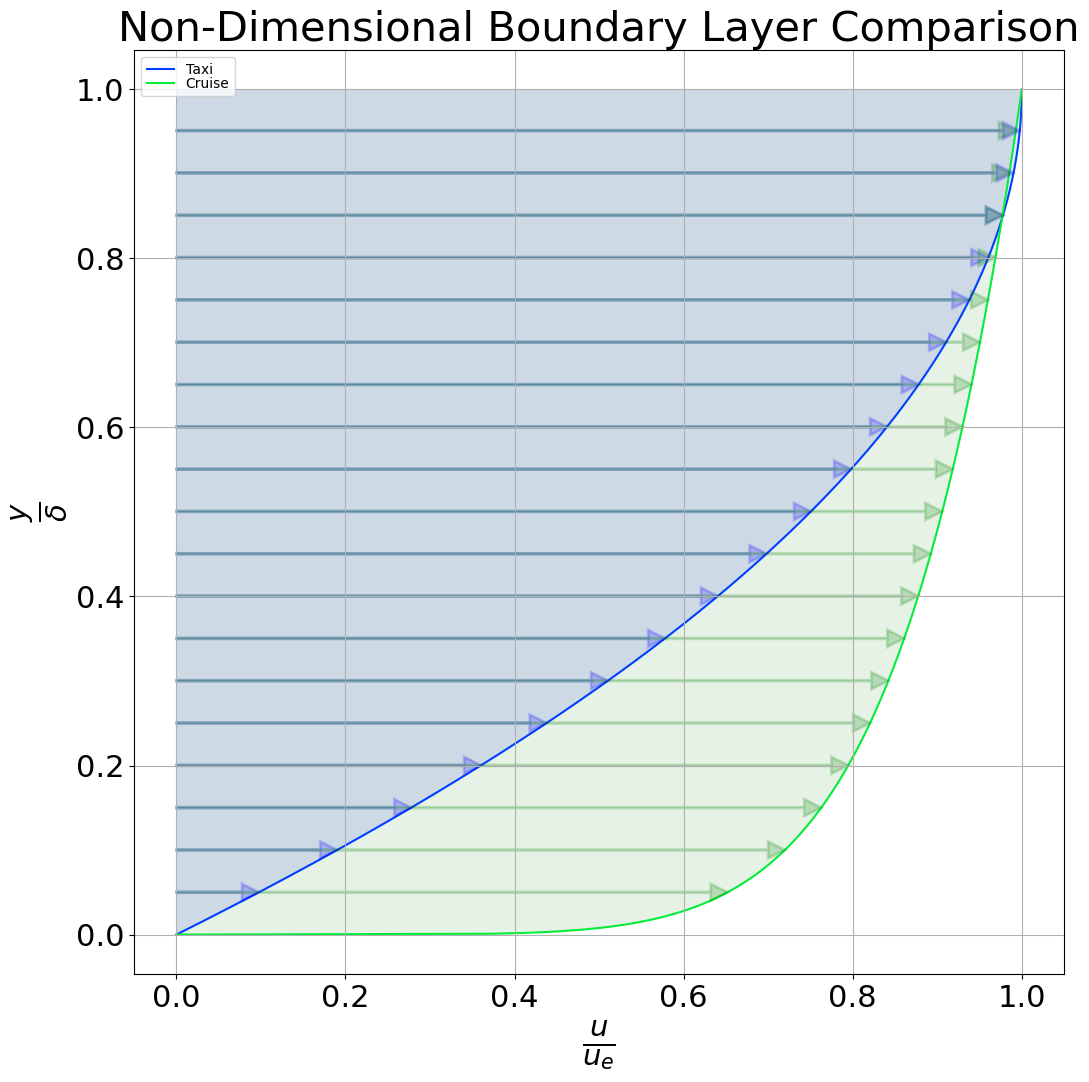

In [4]:
# Problem 1.2

# Laminar boundary layer

laminar_boundary_u_nondim = lambda y_delta: ( 2 * y_delta - (y_delta**2))

# Turbulent Boundary Layer
turbulent_boundary_u_nondim = lambda y_delta: (y_delta**(1/7))

# Data calculation

y_non_dim = np.linspace(0, 1, 1000)

laminar_u_non_dim = laminar_boundary_u_nondim(y_non_dim)
turbulent_u_non_dim = turbulent_boundary_u_nondim(y_non_dim)

fig, non_dim_boundary_layer = plt.subplots()

plothusly(non_dim_boundary_layer,
        laminar_u_non_dim,
        y_non_dim,
        title="Non-Dimensional Boundary Layer Comparison",
        xtitle=r'$\frac{u}{u_e}$',
        ytitle=r"$\frac{y}{\delta}$",
        datalabel="Taxi")

plothus(non_dim_boundary_layer,
        turbulent_u_non_dim,
        y_non_dim,
        datalabel="Cruise")


# Shade in boundary layer
vline = y_non_dim*0
plothus(non_dim_boundary_layer, laminar_u_non_dim, vline, linestyle='')
plt.fill_betweenx(y_non_dim, vline, laminar_u_non_dim, facecolor='b', alpha=0.1)
plt.axis('equal')

# Make Arrows
arrowwidth, arrowlength = 0.02, 0.02

for i in range(0, len(y_non_dim), 50):
    if abs(laminar_u_non_dim[i]) < arrowlength:
        plt.plot([0, laminar_u_non_dim[i]], [y_non_dim[i], y_non_dim[i]], color='b')
    else:
        plt.arrow(0, y_non_dim[i], laminar_u_non_dim[i]-arrowlength, 0, head_width=arrowwidth,
                  head_length=arrowlength, color='b', linewidth=2, alpha=0.2)

plothus(non_dim_boundary_layer, turbulent_u_non_dim, vline, linestyle='')
plt.fill_betweenx(y_non_dim, vline, turbulent_u_non_dim, facecolor='g', alpha=0.1)
plt.axis('equal')

# Make Arrows
arrowwidth, arrowlength = 0.02, 0.02

for i in range(0, len(y_non_dim), 50):
    if abs(turbulent_u_non_dim[i]) < arrowlength:
        plt.plot([0, turbulent_u_non_dim[i]], [y_non_dim[i], y_non_dim[i]], color='g')
    else:
        plt.arrow(0, y_non_dim[i], turbulent_u_non_dim[i]-arrowlength, 0, head_width=arrowwidth,
                  head_length=arrowlength, color='g', linewidth=2, alpha=0.2)
        

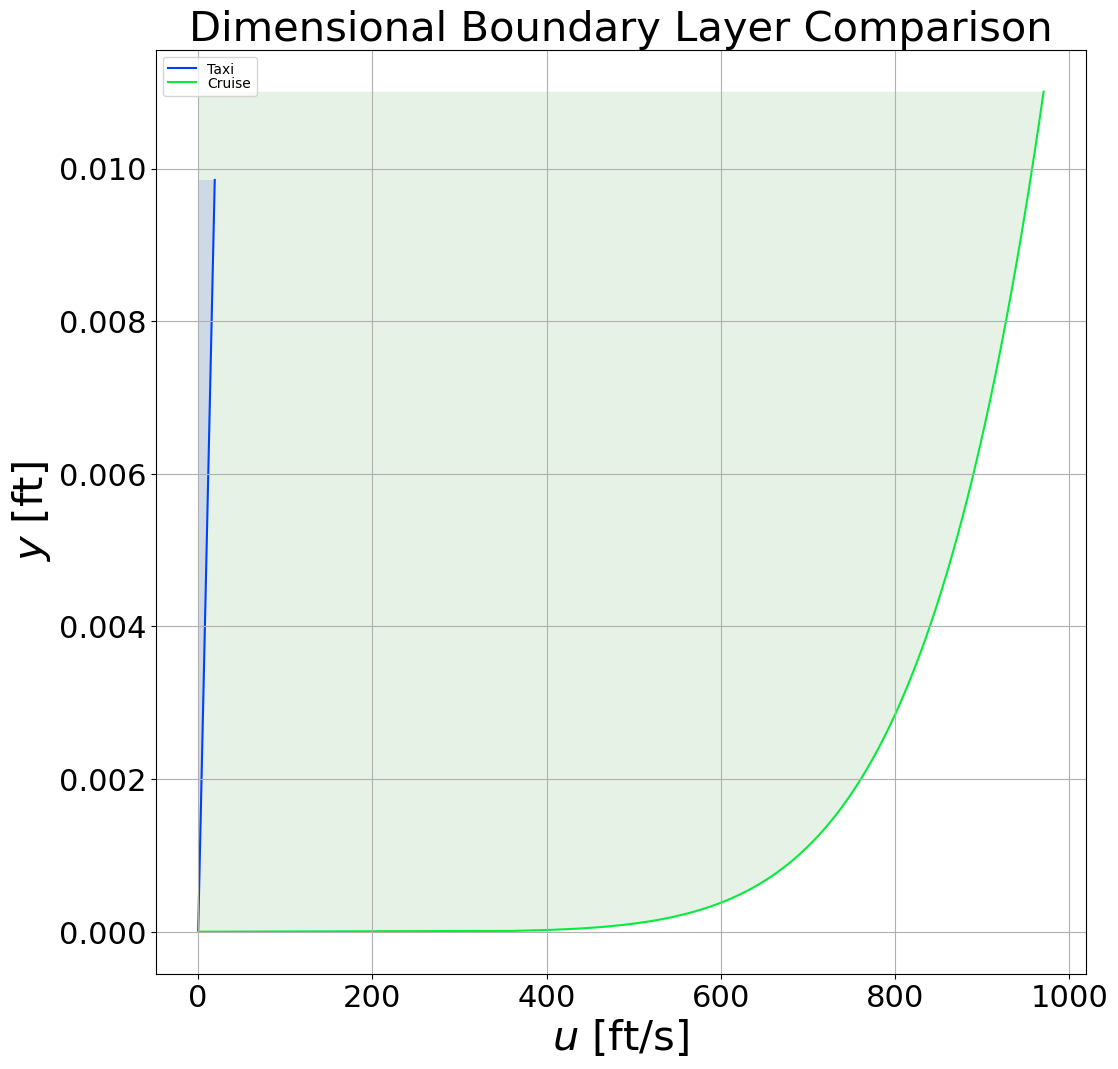

In [5]:
# Laminar Dimensional

delta_x_lam = lambda Re, x: 5.0 * x * (Re**(-1/2))
laminar_y = y_non_dim * delta_x_lam(Reynolds_1, L)
laminar_u = kts2fps(575) * laminar_boundary_u_nondim(laminar_y)
# Turbulent Dimensional

turbulent_u = turbulent_u_non_dim * kts2fps(575)
delta_x_tur = lambda Re, x: 0.16 * x * (Re**(-1/7))
turbulent_y = y_non_dim * delta_x_tur(Reynolds_2, L)


fig, boundary_layer_plot = plt.subplots()

plothusly(boundary_layer_plot,
          laminar_u,
          laminar_y,
          title="Dimensional Boundary Layer Comparison",
          ytitle=r"$y$ [ft]",
          xtitle=r"$u$ [ft/s]",
          datalabel="Taxi")

plothus(boundary_layer_plot,
        turbulent_u,
        turbulent_y,
        datalabel="Cruise")


# Shade in boundary layer
vline = laminar_y*0
plothus(boundary_layer_plot, laminar_u, vline, linestyle='')
plt.fill_betweenx(laminar_y, vline, laminar_u, facecolor='b', alpha=0.1)

vline = turbulent_y*0
plothus(boundary_layer_plot, turbulent_u, vline, linestyle='')
plt.fill_betweenx(turbulent_y, vline, turbulent_u, facecolor='g', alpha=0.1)

Note that the fluid velocity in the turbulent regime is far greater than the laminar regime. Turbulent flow may be preferred in most cases because of this greater momentum, which is better able to resist the effects of an adverse pressure gradient. However, the same greater velocity that reduces APG effects comes with an increased drag force, as the drag force is related to the square of the velocity.

### 1.3 | Friction Drag

Using a flat plate approximation, compute the total friction coefficient on the antenna $C_f$ for both flight conditions. Determine how the friction coefficient would change if the length of the antenna was increased to 12 inches. Determine the significance of this change.

#### 1.3.1 | Approach

Approximation for a flat plat only considers force on a single side of the antenna. Therefore, the drag coefficient must be double to include both sides of the antenna. Equations for friction coefficients in both flow regimes is given in the problem statement. To find the friction coefficient for the longer antenna, the Reynold's number for both must be recalculated for the larger length.

#### 1.3.2 | Equations

Reynold's number is given as:

$$\begin{equation}
    Re = \frac{\rho V L}{\mu}
\end{equation}$$

Coefficient of friction for a laminar flow regime is given as:

$$\begin{equation}
    C_f = 1.328 Re^{-0.5}
\end{equation}$$

Coefficient of friction for a turbulent flow regime is given as:

$$\begin{equation}
    C_f = 0.074 Re^{-\frac{1}{5}}
\end{equation}$$
#### 1.3.3 | Code and Results

In [6]:
# Problem 1.3 

Cflam = lambda Re: 1.328 * (Re**(-1/2))

C_f_laminar = 2 * Cflam(Reynolds_1)

string = f"C_f for condition 1: {C_f_laminar:.4e}"
print(string)


Cftur = lambda Re: 0.074 * (Re**(-1/5))

C_f_turbulent = 2*Cftur(Reynolds_2)
string = f"C_f for condition 2: {C_f_turbulent:.4e}"
print(string)

cf_lam_long = 2 * Cflam(FindReynolds(rho_1, kts2fps(12), 2*L, mu))
cf_tur_long = 2 * Cftur(FindReynolds(rho_2, kts2fps(575), 2*L, mu))

drag_lam_long = 0.5 * rho_1 * kts2fps(12)**2 * cf_lam_long
drag_tur_long = 0.5 * rho_2 * kts2fps(575)**2 * cf_tur_long

string = f"Drag force for double-length antenna at condition 1 is : {drag_lam_long:.5f} lbf"
print(string)

string = f"Drag force for double-length antenna at condition 2 is : {drag_tur_long:.5f} lbf"
print(string)

C_f for condition 1: 1.0465e-02
C_f for condition 2: 9.2091e-03
Drag force for double-length antenna at condition 1 is : 0.00361 lbf
Drag force for double-length antenna at condition 2 is : 3.11708 lbf


Note that the coefficient of drag for the laminar flow regime is greater than the coefficient for the turbulent regime. This does not, however, imply a greater drag force, as the drag force is also dependent on the square of velocity. The calculated drag force on the long antenna for the laminar flow case is relatively small compared to the force required to maintain equilibrium flight, and would not make any significant difference on the thrust requirements for the aircraft. However, in the turbulent flow case, a three pound drag force is a significant effect for a small component. While not significant in regards to equilibrium flight conditions (3lbf difference will not cause a significant reduction in flight speed), the force on the antennamay cause structural issues for the antenna itself.

## 2 | Viscous Inviscid Interactions

This section focuses on the VIvI tool, and its applications and limitations.


### 2.1 | Dividing Streamline Displacement

Describe the solution found by the viscid/inviscid interaction code (referred to and imported as ```vivi``` as provided on canvas, and write pseudo-code detailing the solution to demonstrate understanding of the provided solution. Using the provided code, find "viscid" solutions for a NACA 23012 airfoil ($\alpha = 0$), for 0 to 4 iterations, and plot the resultant geometry. Describe any observed trends. 

Additionally, apply viscous decambering to all solutions, and discuss the concept.

#### 2.1.1 | Approach

Each iteration can be found by looping the VIvI code for the desired number of iterations, using a ```for``` loop. Each iteration can then be plotted on an airfoil geometry graph.

The viscous decambering is achieved by averaging the upper and lower surfaces of the each new airfoil geometry. The resulting camber is then shown on an identical geometry graph, as well as a seperate graph with unequal axes, so as to better show the differences between the two. The geometery is interpolated using the ```mses``` library, averaged, and then returned, creating the camber line.

#### 2.1.2 | Equations

No equations are derived or used for this section, as the code was provided. The ```vivi``` solution, however, relies on the Von Karman integral, applied to the Blasius flat plate solution, expressed as:

$$\begin{equation}
    [\theta(x_0)]^2 = \frac{0.440 \mu}{\rho[u_e(x_0)]^{9.210}} \int_0^{x_0} [u_e(x_0)]^{8.210} dx
\end{equation}$$



#### 2.1.3 | Code and Results

The ```vivi``` is an iterative tool which approximates viscid flow over an airfoil through the use of an inviscid solution, and a flat plate approximation. The general process is described here:

* Obtain an inviscid flow solution around the given geometry using a vortex panel method.
* Use the inviscid flow solution to obtain pressure distribution $C_p(x)$ for the entire airfoil
* Apply the same upper/lower pressure distribution to a flat plate, which has known solutions (The Blasius equation)
* Using the equation for displacement thickness over a flat plate, add the displacement thickness to the airfoil geometry to create new, invsicid airfoil geometry
    * This is valid because the edge of the boundary layer is a streamline, and can therefore be treated as a new, solid surface
* Iterate using the new airfoil geometry

Viscous decambering is an analysis tool by which the flow properties surrounding an airfoil (such as $C_{x)$) are disconnectected from the airfoil geometry, and the magnitude of the property can be compared as a function of the chord length, removing the effect of the camber. 

Viscous decambering is in this problem through a custom function, which averages properties from the upper and lower surfaces, and then returns values with appropriate, interpolated x-points, using the ```mses``` library provided on Canvas:

In [7]:
def CreateCamberLine(df):
    
    
    x = np.linspace(0, 1, 1000)
    up, lo = mses.MsesInterp(x, df.x, df.z)


    avg = up + lo
    avg *= 0.5
    
    return x, avg

Freestream properties are given as part of the problem statement. A 0$^{th}$ iteration for the airfoil is found, and then subsequent iterations are calculated and then added to the same plot using the ```vivi``` tool.

No handles with labels found to put in legend.


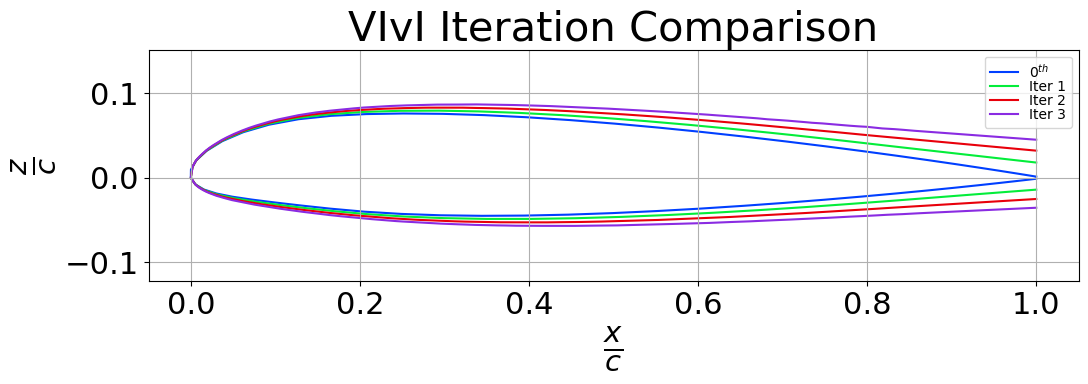

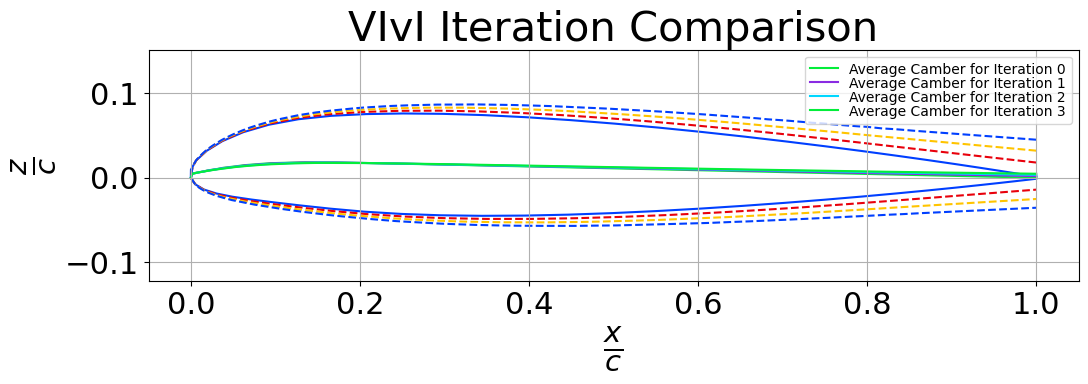

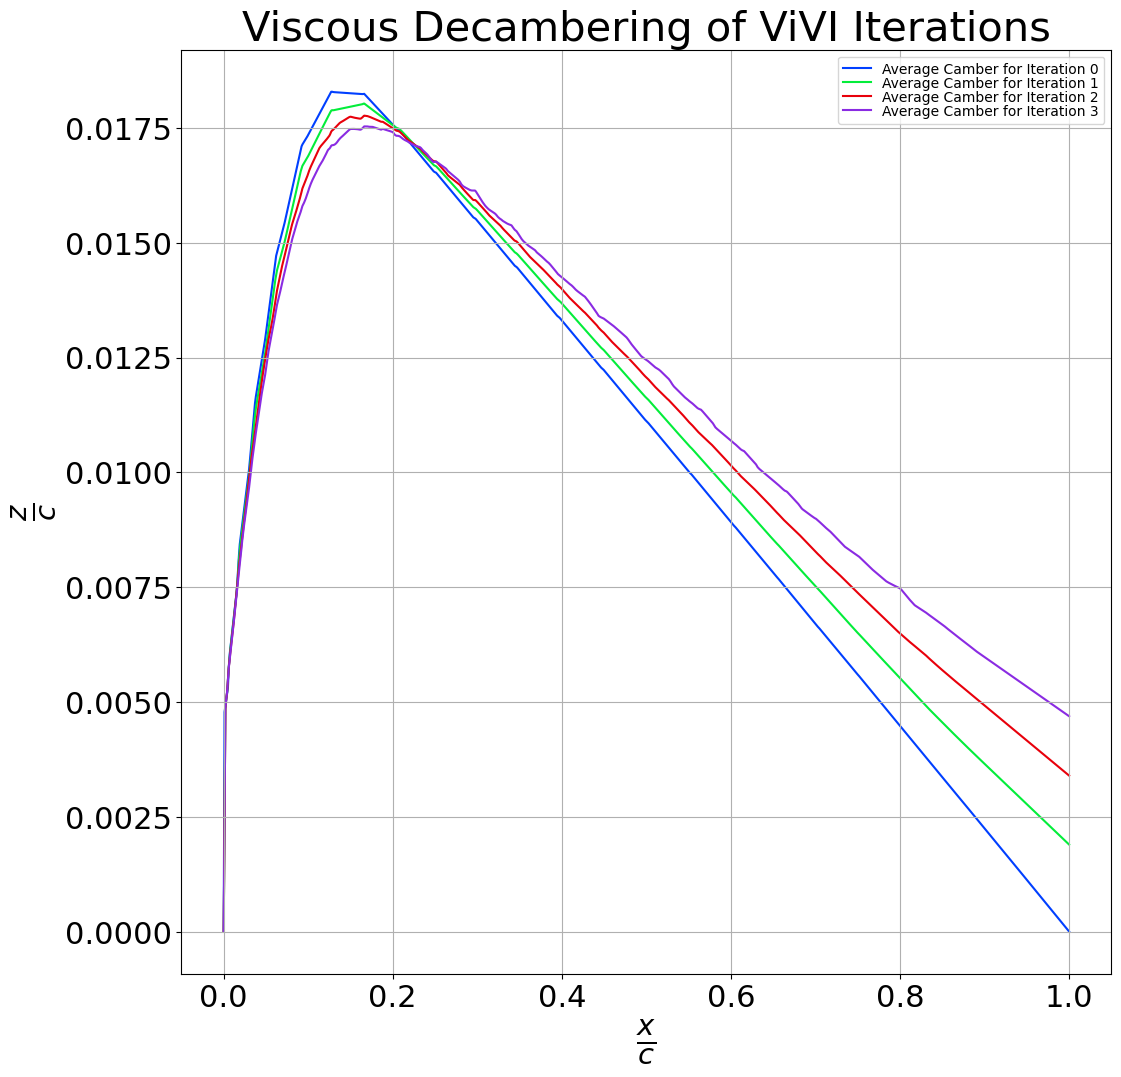

In [8]:
# Problem 2.1

airfoil_name = "naca23012"
alpha = 0
currentiter = 0
V_inf = 1  # m/s
rho = 1.225  # kg/m**3
mu = 1.789E-5



df_mses = pyx.ReadXfoilAirfoilGeom('Data/naca23012/naca23012.dat')

fig, viviplot = plt.subplots(figsize=(12,3))
fig, viviplot2 = plt.subplots(figsize=(12,3))


viviplot.axis('equal')

plothusly(viviplot,
          df_mses["x"],
          df_mses["z"],
          datalabel=r"0$^{th}$",
          xtitle=r"$\frac{x}{c}$",
          ytitle=r"$\frac{z}{c}$",
          title="VIvI Iteration Comparison")



plothusly(viviplot2,
          df_mses["x"],
          df_mses["z"],
          datalabel=r"",
          xtitle=r"$\frac{x}{c}$",
          ytitle=r"$\frac{z}{c}$",
          title="VIvI Iteration Comparison")

x_avg, z_avg = CreateCamberLine(df_mses)

plothus(viviplot2,
        x_avg,
        z_avg,
        datalabel=fr"Average Camber for Iteration {currentiter}")

plt.axis("equal")

fig, camberplot = plt.subplots()

plothusly(camberplot,
          x_avg,
          z_avg,
          datalabel=fr"Average Camber for Iteration {currentiter}",
          xtitle=r"$\frac{x}{c}$",
          ytitle=r"$\frac{z}{c}$",
          title="Viscous Decambering of ViVI Iterations")

for currentiter in range(4):
    
    theta_up, ue_up, theta_lo, ue_lo = vivi.VIvI(airfoil_name,
                                                 alpha,
                                                 currentiter,
                                                 V_inf,
                                                 mu,
                                                 rho)
    
    
    if currentiter is not 0:
        df_disp = pyx.ReadXfoilAirfoilGeom(f"Data/naca23012/naca23012_{currentiter}.dat")
    
        plothus(viviplot,
                df_disp["x"],
                df_disp["z"],
                datalabel=rf"Iter {currentiter}",
                linestyle='-')
        
        plothus(viviplot2,
                df_disp["x"],
                df_disp["z"],
                datalabel=rf"",
                linestyle='--')
        
        x, z = CreateCamberLine(df_disp)
        
        plothus(viviplot2,
                x, z,
                datalabel=f"Average Camber for Iteration {currentiter}")
        
        plothus(camberplot,
                x, z,
                datalabel=f"Average Camber for Iteration {currentiter}")

Note that the solution does not converge in this case. 

Observe the first graph: as the number of iterations increases, so too does the airfoil geometry, adding the calculated momentum thickness from the previous iteration. If the solution were to converge, we could expect to see the magnitude of the change in the geometry decreasing, and approach zero, but that is not the case here. Note that the trailing edge is the most effected in each iteration, while the leading edge is unchanged.

Now observe the third graph: Note that while the general shape of the decambered airfoil is similar, iteration causes changes in two key areas. First, note the peak at $\frac{x}{c} \approx 0.15$; as the iteration number increases, the peak value at that point decreases. All values intersect at $\frac{x}{c} \approx 0.15$, but differ in slope, with reduced slope magnitudes for increasing iteration numbers. 

In the case of failure to converge, the best solution for the VIvI tool would be to perform a pre-determined number of iterations.

### 2.2 | Viscous Force Coefficients

For the third ViVI iteration, compute lift and drag coefficients.

#### 2.2.1 | Approach

The 3rd iteration geometry is already solved for in the previous problem. The coefficient of lift can be solved for by running an invsicid XFOIL simulation on the geometry for the iteration, which can be called using ```pyxfoil```.

The drag coefficient is trickier to find. XFOIL will not yield a result for pressure drag in an inviscid solution. However, frictional drag can be found using the momentum thickness. A relation between momentum thickness and wall shear stress is derived in the following section. By determining wall shear stress at every point along the airfoil, local frictional coefficient $c_f$ can be found at every point, and integrated to find the total frictional drag coefficient $C_f$. VIvI yields momentum thickness data from an inviscid XFOIL solution (specifically from the pressure distribution), which is used to determine $\theta$. Note that both the upper and lower surfaces must be integrated, as both contribute the frictional drag.

#### 2.2.2 | Equations

Wall shear stress $\tau$ is given by the equation:

$$\begin{equation}
    \tau = 0.332 \frac{\mu u_e}{x} Re^{0.5}
\end{equation}$$

and momentum thickness $\theta$ is given by:

$$\begin{equation}
    \theta = \frac{0.664 x}{Re^{0.5}}
\end{equation}$$

The two can be related by first solving for Reynold's number, and are found as:

$$\begin{equation}
    \frac{\tau x}{0.332 \mu u_e} = Re^{0.5} = \frac{0.664 x}{\theta}
\end{equation}$$

Solving for $\tau$:

$$\begin{equation}
    \tau = \frac{(0.664)(0.332)\mu u_e}{\theta}
\end{equation}$$

Note that $\tau$ is an inverse function of $\theta$. The first few values for momentum thickness are zero, and will therefore cause infinite values. These first two values are then discarded, which, while resulting in a less accurate solution, will allow the system to be solved.

The resulting stress distribution can then be integrated along the entire airfoil to find the total frictional drag:

$$\begin{equation}
    c_f = \int_0^c \frac{\tau}{0.5 \rho V_\infty^2} dx 
\end{equation}$$

#### 2.2.3 | Code and Results

In [9]:
# Problem 2.2

pyx.GetPolar(foil="Data/naca23012_3/naca23012_3.dat", naca=False)

third_iter_dat = pyx.ReadXfoilPolar("Data/naca23012_3/naca23012_3_polar_Re0.00e+00a0.00.dat")


# Uses library not found in standard anaconda distribution, and is therefore commented out.
# print(third_iter_dat.to_markdown())


theta_lo = theta_lo.to_numpy()[2:len(theta_lo)]
theta_up = theta_up.to_numpy()[2:len(theta_up)]
ue_up = ue_up.to_numpy()[2:len(ue_up)]
ue_lo = ue_lo.to_numpy()[2:len(ue_lo)]

# Find tau at every point
tau_find = lambda mu, ue, theta: 0.664 * 0.332 * mu * ue / theta

tau_lo = tau_find(mu, ue_lo, theta_lo)
tau_up = tau_find(mu, ue_up, theta_up)

cf = lambda tau: tau * (0.5 * rho * V_inf**2)**-1

cf_lo = cf(tau_lo)
cf_up = cf(tau_up)

x = df_disp.x.to_numpy()
x = np.flip(x[2:len(tau_lo)+2])


Cf_lo = np.trapz(cf_lo, x)
Cf_up = np.trapz(cf_up, x)

Cf = Cf_lo + Cf_up


string = f'Friction Coefficent for 3rd iteration = {Cf}'
print(string)

Re_3 = FindReynolds(rho, V_inf, 1, mu)

string = f"Reynold's number is {Re_3:.2e}"
print(string)

pyx.GetPolar(foil='23012', naca=True, alfs=0, Re=Re_3)
pyx.GetPolar(foil='23012', naca=True, alfs=0, Re=0)

visc = pyx.ReadXfoilPolar("Data/naca23012/naca23012_polar_Re6.85e+04a0.00.dat")
invisc = pyx.ReadXfoilAirfoilGeom("Data/naca23012/naca23012_polar_Re0.00e+00a0.00.dat")

Friction Coefficent for 3rd iteration = 0.012407362988945965
Reynold's number is 6.85e+04


| Simulation Used | Cl     | Cd      |
|-----------------|--------|---------|
| VIvI            | 0.0919 | 0.01240 |
| Xfoil Inviscid  | 0.1376 | 0.00000 |
| Xfoil Viscid    | 0.2497 | 0.01856 |

Note that the Reynolds number for this condition falls below the given transition point, and is therefore conisdered laminar. Also note that there is a large error between the viscid and inviscid XFOIL results, and the ViVI solution. The error between the drag coefficients for the ViVI and XFOIL solutions is likely due to the inclusion of pressure drag in the XFOIL result, which the ViVI solution does not account for (only friction drag is accounted for). The large difference in the coefficient of lift is likely the result of the use of the modified geometry to calculate lift. The modified geometry has a larger thickness at the aft of the airfoil, which is likely the cause of the unrealistic $C_l$. The ViVI solution has, however, a coefficient of frictional drag, which the inviscid XFOIL solution cannot provide.

### 2.3 | Assumptions and Limitations

Discuss the limitations of the ViVI tool.

#### 2.3.1 | Response

The ViVI tool is limited by the many assumptions and approximations required. It relies on a base inviscid solution, and as such is limited by the same properties as any potential flow solution. As such, it would be inappropriate to use this solution for high Reynold's numbers, large angles of attack, or where the flow cannot be considered incompressible. Additionally, the solution is limited by assumption of the boundary layer thickness of the airfoil as a flat plate. While this may be valid for thin airfoils, this assumption will not remain valid for thicker airfoils. 

One way to potentially increase the fidelity of the solution would be to increase the number of intervals at which each value is calculated. This will reduce any error caused by numerical differentiation/integration, as well as reduce the error caused by dropping the 0 $\theta$ terms at the leading edge of the airfoil.

## 3 | Conclusion

Viscid effects are a key part of aerodynamics that cannot be ignored. 

The VIvI tool is useful for finding frictional drag effects on an airfoil, but in many cases fails to converge correctly. A high number of points used in the calculation may aid in convergence, but in most cases the solution will be more accurate with a limited number of iterations. It does, however, provide a much more accurate representation of drag than a potential flow solution alone. As such, it is reccomended to use the VIvI solver in conjunction with an existing vortex panel method solution, to find drag and lift forces respectively.